**MITx 6.419x  Data Analysis: Statistical Modeling and Computation in Applications**  
Written report -- Homework 2  
Student Name (Xing Zhang)  
Collaborators: none  
3/29/21  
---

## Problem 2: Larger unlabeled subset

### Part 1: Visualization

>A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflects in the data.


  
> **1.** Provide at least one visualization which clearly shows the existence of the three main brain cell types described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.  


## solutions

In [429]:
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import heapq
import random 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#### 1. Load the data

In [430]:
X = np.load(r'D:\documents\my work\jupyter notebook\data\p2_unsupervised\X.npy')

#### 2. Log transform

In [431]:
X_log = np.log2(X + 1)

In [432]:
X_log.shape

(2169, 45768)

#### 3. Visualization

#### 3.1 PCA

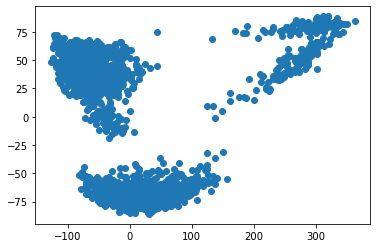

In [436]:
pca = PCA().fit(X)
pca_log = PCA().fit(X_log)
z = pca_log.transform(X_log)
plt.scatter(z[:,0],z[:,1])

It can be clearly seen that there are three main separate clusters

#### 3.2 MDS

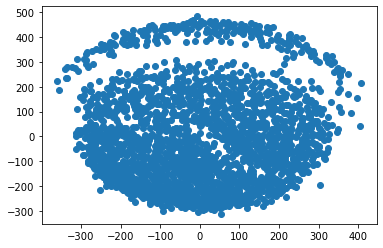

In [437]:
 mds=MDS(n_components=2).fit_transform(X_log)
plt.scatter(mds[:,0],mds[:,1])

It can be clearly seen that there are three main separate clusters

#### 3.3 T-SNE

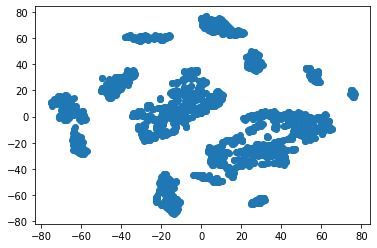

In [438]:
z_tsne = TSNE(n_components=2,perplexity=20).fit_transform(z[:,0:10])
plt.scatter(z_tsne[:,0],z_tsne[:,1])

It can be clearly seen that there are multiple main separate clusters

  
> **2.** Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.


##### It can be clearly seen that within each of the three types, there are numerous possible sub-types for a cell.

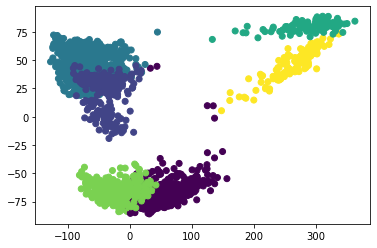

In [439]:
kmeans = KMeans(6, tol=1e-7)
kmeans.fit(z[:,0:10])
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)

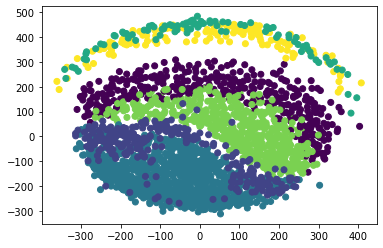

In [440]:
 plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)

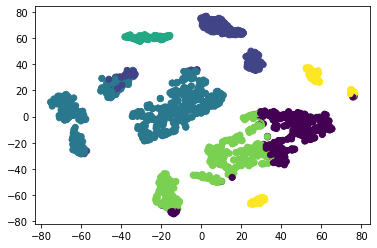

In [441]:
# T-SNE plot
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)

##  
#### Part 2: Unsupervised Feature Selection

> Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the `p2_unsupervised` dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in `p2_evaluation`, and run it on the test set in the same folder.


  
>**1.** Using your clustering method(s) of choice, find a suitable clustering for the cells. Support your choice of clustering with appropriate visualizations and/or numerical findings. Be sure to briefly explain how you chose the number of clusters.


###### Elbow method+Silhouette score seem to converge on 6 clusters.

Num clusters 2 Inertia: 23087622.110058594
Num clusters 3 Inertia: 14559642.898322664
Num clusters 4 Inertia: 12360482.372908281
Num clusters 5 Inertia: 10657852.882795962
Num clusters 6 Inertia: 9333109.009085776
Num clusters 7 Inertia: 7972600.206293359
Num clusters 8 Inertia: 7047875.286022899
Num clusters 9 Inertia: 6147999.919045893
Num clusters 10 Inertia: 5659146.404939472
Num clusters 11 Inertia: 5240503.301489311


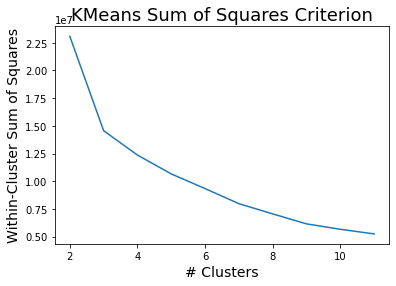

In [442]:
all_kmeans = [i for i in range(10)]
for i in range(10):
    cur_kmeans = KMeans(i+1)
    cur_kmeans.fit(z[:,0:10])
    print("Num clusters", i+1, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+1 for i in range(10)], [all_kmeans[i].inertia_ for i in range(10)])
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()

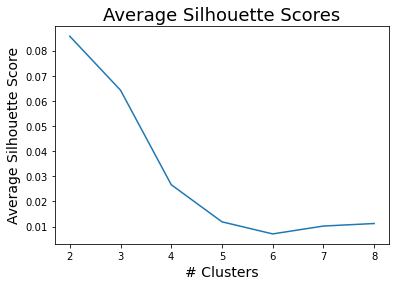

In [443]:
from sklearn.metrics import silhouette_score, silhouette_samples
avg_silhouette_scores = [silhouette_score(z,all_kmeans[i].labels_) for i in range(1,8)]
plt.plot(np.arange(2,9),avg_silhouette_scores)
plt.title("Average Silhouette Scores",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Average Silhouette Score",size=14)
plt.show()

  
>**2.** We will now treat your cluster assignments as labels for supervised learning. Fit a logistic regression model to the original data (not principal components), with your clustering as the target labels. Since the data is high-dimensional, make sure to regularize your model using your choice of $\ell _1$, $\ell _2$, or elastic net, and separate the data into training and validation or use cross-validation to select your model. Report your choice of regularization parameter and validation performance.


Separate into train and test data

In [444]:
np.random.seed(2169)
perm = np.random.permutation(X.shape[0])
n_train = int(4/5*X.shape[0])
X_train = X[perm[:n_train]]
y_train = kmeans.labels_[perm[:n_train]]
X_test = X[perm[n_train:]]
y_test = kmeans.labels_[perm[n_train:]]

##### training and validation

In [445]:
log_reg = LogisticRegression(penalty="none",multi_class="ovr").fit(X_train,y_train)

In [446]:
log_reg.score(X_train,y_train)

1.0

In [447]:
log_reg.score(X_test,y_test)

0.9493087557603687

##### Cross Validation

In [448]:
log_reg = LogisticRegression(penalty="l1",C=0.1,solver="liblinear",max_iter=5000,multi_class="ovr").fit(X_train,y_train)
log_reg.score(X_train,y_train)

1.0

In [449]:
log_reg.score(X_test,y_test)

0.956221198156682

In [450]:
log_reg = LogisticRegressionCV(cv=5,Cs=[0.01,0.1,1,10],max_iter=5000,penalty="l1",solver="liblinear",multi_class="ovr")
log_reg.fit(X_train,y_train)
log_reg.score(X_train,y_train)

1.0

In [451]:
log_reg.C_

array([1.  , 0.01, 0.1 , 0.01, 0.1 , 0.01])

In [452]:
log_reg.scores_

{0: array([[0.93659942, 0.93659942, 0.94236311, 0.93948127],
        [0.9481268 , 0.95677233, 0.95965418, 0.9481268 ],
        [0.96541787, 0.96253602, 0.96541787, 0.95677233],
        [0.95100865, 0.96541787, 0.97118156, 0.9740634 ],
        [0.97694524, 0.98559078, 0.98559078, 0.96253602]]),
 1: array([[0.98847262, 0.98559078, 0.98270893, 0.98270893],
        [0.98847262, 0.97982709, 0.97982709, 0.97694524],
        [0.98559078, 0.99135447, 0.99423631, 0.99135447],
        [0.99711816, 0.99135447, 0.99711816, 0.99711816],
        [0.98847262, 0.98847262, 0.99135447, 0.99135447]]),
 2: array([[0.98270893, 0.98559078, 0.98559078, 0.98270893],
        [0.99423631, 0.98847262, 0.98559078, 0.97982709],
        [0.98270893, 0.98559078, 0.98559078, 0.98559078],
        [0.99135447, 1.        , 0.99711816, 0.99423631],
        [0.99135447, 0.99135447, 0.99135447, 0.98847262]]),
 3: array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        

In [453]:
log_reg.score(X_test,y_test)

0.9608294930875576

  
>**3.** Select the features with the top 100 corresponding coefficient values (since this is a multi-class model, you can rank the coefficients using the maximum absolute value over classes, or the sum of absolute values). Take the evaluation training data and use a subset of the genes, consisting of the features you selected. Train a logistic regression classifier on this training data, and evaluate its performance on the evaluation test data. Report your score. Compare with two baselines: random features (take a random selection of 100 genes), and high-variance features (take the 100 genes with highest variance). Compare the variances of the features you selected with the highest variance features by plotting a histogram of the variances of features selected by both methods.


##### Selecting features

In [454]:
log_reg.coef_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

look at sum of absolute value per column

In [455]:
a = np.sum(np.abs(log_reg.coef_),axis=0)

a.shape

(45768,)

##### Select the features with the top 100 corresponding coefficient values.

In [456]:
ind = np.argpartition(a, -100)[-100:]

##### Take the evaluation training data and use a subset of the genes, consisting of the features selected. Train a logistic regression classifier on this training data. 

In [457]:
X_evaluation_train = np.load(r'D:\documents\my work\jupyter notebook\data\p2_evaluation\X_train.npy')
y_evaluation_train = np.load(r'D:\documents\my work\jupyter notebook\data\p2_evaluation\y_train.npy')
X_evaluation_test = np.load(r'D:\documents\my work\jupyter notebook\data\p2_evaluation\X_test.npy')
y_evaluation_test = np.load(r'D:\documents\my work\jupyter notebook\data\p2_evaluation\y_test.npy')

In [458]:
log_reg = LogisticRegressionCV(cv=5,Cs=[0.001,0.01,0.1,1,10],max_iter=5000,penalty="l1",solver="liblinear",multi_class="ovr")
log_reg.fit(X_evaluation_train[:,np.array(ind)],y_evaluation_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=5000,
                     multi_class='ovr', penalty='l1', solver='liblinear')

##### evaluate its performance on the evaluation test data.The score is 0.9972144846796658 and 0.8366425992779783

In [459]:
log_reg.score(X_evaluation_train[:,np.array(ind)],y_evaluation_train)

0.9721448467966574

In [460]:
log_reg.score(X_evaluation_test[:,np.array(ind)],y_evaluation_test)

0.8149819494584838

##### Select the features with the random 100 corresponding coefficient values.

In [461]:
b = np.arange(0,45768,1)
random_100 = random.sample(list(b), 100)
random_100_value = random_100

##### Take the evaluation training data and use a subset of the genes, consisting of the features random selected. Train a logistic regression classifier on this training data. 

In [477]:
log_reg = LogisticRegressionCV(cv=5,Cs=[0.001,0.01,0.1,1,10],max_iter=5000,penalty="l1",solver="liblinear",multi_class="ovr")
log_reg.fit(X_evaluation_train[:,np.array(random_100_value)],y_evaluation_train)

LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=5000,
                     multi_class='ovr', penalty='l1', solver='liblinear')

##### evaluate its performance on the evaluation test data.The score is 0.05013927576601671 and 0.05144404332129964

In [478]:
log_reg.score(X_evaluation_train[:,np.array(random_100)],y_evaluation_train)

0.47818012999071496

In [479]:
log_reg.score(X_evaluation_test[:,np.array(random_100)],y_evaluation_test)

0.36462093862815886

In [480]:
top_features_variances = np.std(X_evaluation_train[:,np.array(ind)], axis=0)
print(top_features)

[ 73.47172486 326.24438272 108.45449964  88.54115119 225.01492049
 118.44322177 396.33045666 258.24408337 104.34655665  70.16814612
 216.72510726 119.01111165 490.7318292  400.5443868  548.41345281
 192.92072056  81.28758568 129.53438132 116.98502604  61.61814681
 161.62532861 110.25256033 168.54073105 104.32394296 125.72891394
 197.51435034  91.50971798  84.63627245 149.4740129  388.24068713
 129.25895073 138.23613495  60.62899242  72.42417825  66.31328243
  79.87206147 120.6260506  149.44064874 130.16799899 207.35426108
  80.45740171  67.60815775 122.85038965 150.29042211  96.80129764
 175.20514976 116.91377669 107.84631168 178.78645814  71.51361339
  78.55727597 178.8199385   94.74560125 115.46840278 197.93200933
  63.12383982  58.60826343  52.87790982 128.67527643  90.18846697
 165.00203307 126.08933878  94.91663896 108.92876405  46.41224394
 364.10372901  55.85234825 105.80267912 453.24250184 160.16003197
 128.01785009  72.59439499  48.08552877 172.97734486 163.52379628
  97.69315

In [481]:
random_features_variances = np.std(X_evaluation_train[:,np.array(random_100_value)], axis=0)
print(random_features)

[2.85086844e+00 1.27855788e+00 1.83989162e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.76004738e+00
 0.00000000e+00 1.20799666e-01 4.06323696e+00 2.07579064e+01
 1.71550801e-02 1.39161738e-01 1.19639003e+01 3.28584907e+00
 4.57710501e-01 0.00000000e+00 3.09857403e-02 4.44982505e-02
 1.69332600e+01 6.11086938e-02 4.35236990e-02 0.00000000e+00
 1.28394722e-01 1.63523796e+02 0.00000000e+00 5.74482423e+00
 0.00000000e+00 2.56943916e+00 9.41667530e-01 0.00000000e+00
 3.35365631e-01 1.48390827e-02 1.45921782e-02 3.48853101e+00
 4.18625732e-01 0.00000000e+00 3.39865482e-02 1.52743827e+00
 0.00000000e+00 9.04019930e-02 1.71798586e+02 4.10026517e+01
 2.84441761e-02 6.86735508e+01 0.00000000e+00 3.21486593e+02
 1.46794516e+02 2.36319117e-01 6.98567051e-01 2.17906034e+00
 6.05653088e+00 8.04949959e+01 5.02564323e-01 9.96919817e-01
 1.05581675e+02 7.90433330e-01 3.45767972e+01 6.93843386e+00
 6.77272666e-01 3.78802099e-01 8.46092231e+01 0.00000000e+00
 1.62549365e-02 0.000000

##### histogram of the variances of top 100 features

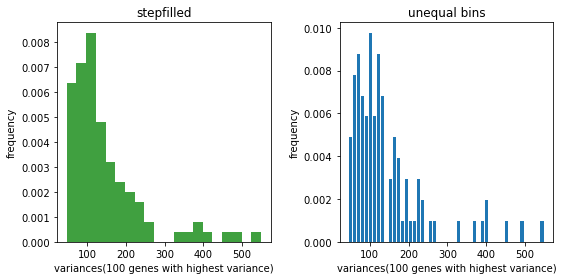

In [482]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))
ax0.hist(top_features, 20, density=True,histtype='stepfilled', facecolor='g', alpha=0.75)
ax0.set_title('stepfilled')
ax0.set_ylabel('frequency')
ax0.set_xlabel('variances(100 genes with highest variance)')
# Create a histogram by providing the bin edges (unequally spaced).
bins = np.linspace(min(top_features),max(top_features))
ax1.hist(top_features, bins, density=True, histtype='bar', rwidth=0.8)
ax1.set_title('unequal bins')
ax1.set_ylabel('frequency')
ax1.set_xlabel('variances(100 genes with highest variance)')
fig.tight_layout()
plt.show()


##### histogram of the variances of random 100 features

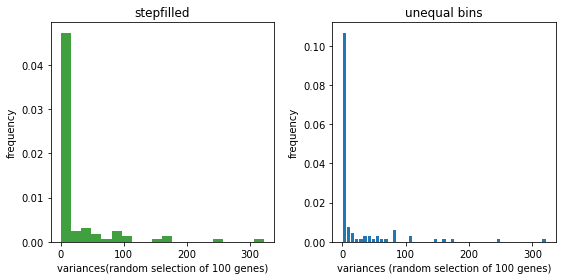

In [483]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))

ax0.hist(random_features, 20, density=True,histtype='stepfilled', facecolor='g', alpha=0.75)
ax0.set_title('stepfilled')
ax0.set_ylabel('frequency')
ax0.set_xlabel('variances(random selection of 100 genes)')
# Create a histogram by providing the bin edges (unequally spaced).
bins = np.linspace(min(random_features),max(random_features))
ax1.hist(random_features, bins, density=True, histtype='bar', rwidth=0.8)
ax1.set_title('unequal bins')
ax1.set_ylabel('frequency')
ax1.set_xlabel('variances (random selection of 100 genes)')
fig.tight_layout()
plt.show()

  
### 6. Problem 3: Influence of Hyper-parameters

> The hyper-parameter choices used in data analysis techniques can have a large impact on the inferences made. As you may have encountered, finding the best choice of parameter such as perplexity in T-SNE or the number of clusters can be an ambiguous problem. We will now investigate the sensitivity of your results to changes in these hyper-parameters, with the goal of understanding how your conclusions may vary depending on these choices.


  
>**1.** When we created the T-SNE plot in Problem 1, we ran T-SNE on the top 50 PC's of the data. But we could have easily chosen a different number of PC's to represent the data. Run T-SNE using 10, 50, 100, 250, and 500 PC's, and plot the resulting visualization for each. What do you observe as you increase the number of PC's used?


##### As the number of PC increases, the cluster starts to overlap.

Text(0.5, 1.0, 'TSNE on first 10 PCs')

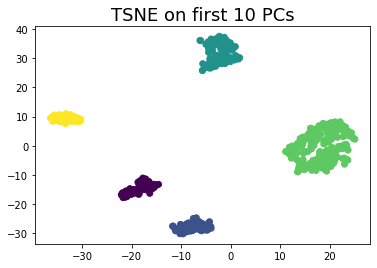

In [470]:
X_p3 = np.load(r'D:\documents\my work\jupyter notebook\data\p1\X.npy')
y_p3 = np.load(r'D:\documents\my work\jupyter notebook\data\p1\y.npy')
X_p3_log = np.log2(X_p3 + 1)
pca_log = PCA().fit(X_p3_log)
z_p3 = pca_log.transform(X_p3_log)
z_p3_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_p3[:,0:10])
plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1], c=y_p3)
plt.title("TSNE on first 10 PCs",size=18)

Text(0.5, 1.0, 'TSNE on first 50 PCs')

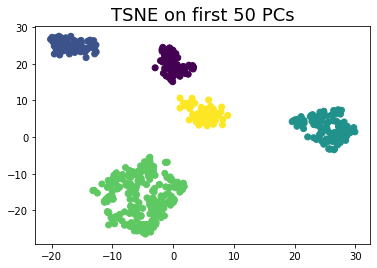

In [471]:
z_p3_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_p3[:,0:50])
plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1], c=y_p3)
plt.title("TSNE on first 50 PCs",size=18)

Text(0.5, 1.0, 'TSNE on first 100 PCs')

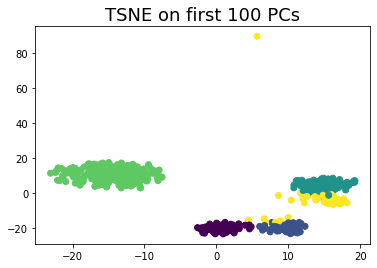

In [472]:
 z_p3_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_p3[:,0:100])
plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1], c=y_p3)
plt.title("TSNE on first 100 PCs",size=18)

Text(0.5, 1.0, 'TSNE on first 250 PCs')

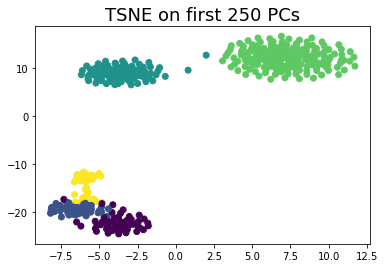

In [473]:
z_p3_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_p3[:,0:250])
plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1], c=y_p3)
plt.title("TSNE on first 250 PCs",size=18)

Text(0.5, 1.0, 'TSNE on first 500 PCs')

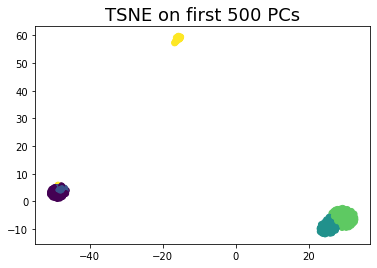

In [474]:
z_p3_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z_p3[:,0:500])
plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1], c=y_p3)
plt.title("TSNE on first 500 PCs",size=18)

  
>**2.** Pick three hyper-parameters below and analyze how changing the hyper-parameters affect the conclusions that can be drawn from the data. Please choose at least one hyper-parameter from each of the two categories (visualization and clustering/feature selection). At minimum, evaluate the hyper-parameters individually, but you may also evaluate how joint changes in the hyper-parameters affect the results. You may use any of the datasets we have given you in this project. For visualization hyper-parameters, you may find it productive to augment your analysis with experiments on synthetic data, though we request that you use real data in at least one demonstration.
Some possible choices of hyper-parameters are:

> **Category A (visualization):**
>- T-SNE perplexity
>- T-SNE learning rate
>- T-SNE early exaggeration
>- T-SNE initialization
>- T-SNE number of iterations/convergence tolerance

> **Category B (clustering/feature selection):**
>- Effect of number of PC's chosen on clustering
>- Type of clustering criterion used in hierarchical clustering (single linkage vs ward, for example)
>- Number of clusters chosen for use in unsupervised feature selection and how it affects the quality of the chosen features
>- Magnitude of regularization and its relation to your feature selection (for example, does under or over-regularizing the model lead to bad features being selected?)
>- Type of regularization ($L^1$, $L^1$, elastic net) in the logistic regression step and how the resulting features selected differ

> For visualization hyper-parameters, provide substantial visualizations and explanation on how the parameter affects the image.

> For clustering/feature selection, provide visualizations and/or numerical results which demonstrate how different choices affect the downstream visualizations and feature selection quality.

> Provide adequate explanations in words for each of these visualizations and numerical results.  


##### Category A : perplexity(visualization)
when start increasing the perplexity, the data points are starting to get a little more spread out and large spaces between points are starting to diminish. When perplexity reaches 50, the separation is best. And if further increase the perplexity, then it starts to not really show you too much about this cluster structure of the data.

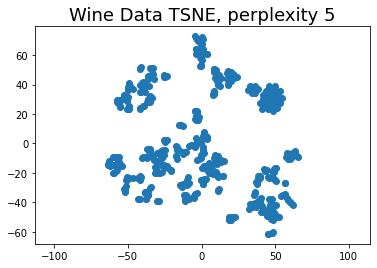

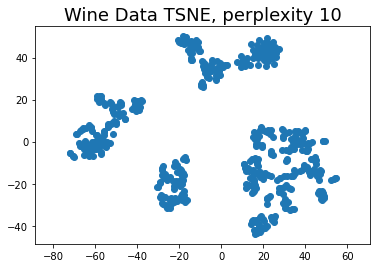

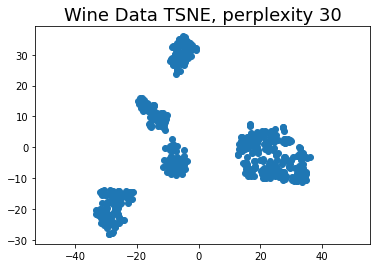

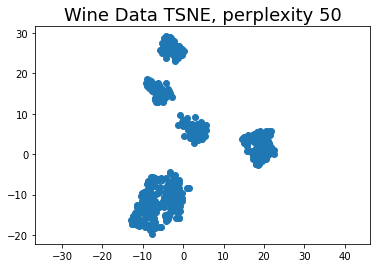

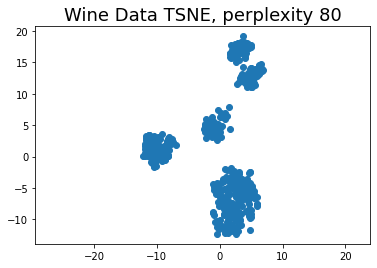

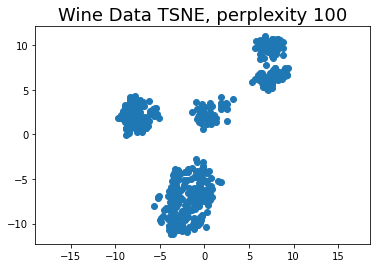

In [475]:
for perplexity in [5,10,30,50,80,100]:
    z_p3_tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(z_p3[:,0:50])
    plt.scatter(z_p3_tsne[:,0],z_p3_tsne[:,1])
    plt.title("Wine Data TSNE, perplexity "+str(perplexity),size=18)
    plt.axis("equal")
    plt.show()

##### Category B:Number of clusters chosen for use in unsupervised feature selection and how it affects the quality of the chosen features (clustering/feature selection) 
When number of clusters increases, the variance begins to decrease. Considering the problems of under-fitting and computational efficiency, an appropriate value can be selected, such as 6 clusters.

Num clusters 2 Inertia: 9520809.578746002
Num clusters 3 Inertia: 7257882.201193227
Num clusters 4 Inertia: 6202929.841899465
Num clusters 5 Inertia: 5801585.180913826
Num clusters 6 Inertia: 5560912.254836461
Num clusters 7 Inertia: 5369022.048566246
Num clusters 8 Inertia: 5274160.902013125
Num clusters 9 Inertia: 5152180.9127301555


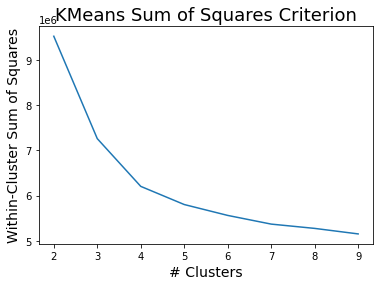

In [476]:
# Would select 3, 4, or 5 clusters
all_kmeans = [i for i in range(8)]
for i in range(8):
    cur_kmeans = KMeans(i+1)
    cur_kmeans.fit(z_p3[:,0:50])
    print("Num clusters", i+1, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+1 for i in range(8)], [all_kmeans[i].inertia_ for i in range(8)])
plt.title("KMeans Sum of Squares Criterion",size=18)
plt.xlabel("# Clusters",size=14)
plt.ylabel("Within-Cluster Sum of Squares",size=14)
plt.show()